## GR5241 Homework 4
### Name: Kangshuo Li           UNI: kl3259

<br>

![](GR5241_HW4_Q5_1.png)
![](GR5241_HW4_Q5_2.png)
![](GR5241_HW4_Q5_3.png)
![](GR5241_HW4_Q5_4.png)

#### Setup

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib
from matplotlib import pyplot as plt
import os
import time
%xmode plain
os.getcwd()

Exception reporting mode: Plain


'/Users/kangshuoli/Documents/VScode_workspace/GR5241/GR5241_HW4'

#### Read in data

In [2]:
feature_df = pd.read_csv("features.txt", header = None)
target_df = pd.read_csv("target.txt", header = None)
assert feature_df.shape == (6414,122)
assert target_df.shape == (6414, 1)

#### 5.
##### (a)

In [9]:
def my_SVM(method, x_ = feature_df, y_ = target_df):
    n = x_.shape[0]
    d = x_.shape[1]
    y_ = np.array(y_).ravel()
    def L(w, b, x_i, y_i):
        return max(0, (1 - y_i * (w.T @ x_i + b)))

    def cost(w, b, C, x_ = x_, y_ = y_):
        sum_L = 0
        for i in np.arange(n):
            sum_L += L(w, b, np.array(x_.iloc[i, :]).T, int(y_[i]))
        return (1 / 2) * w.T @ w + C * sum_L

    def gradient_w(w, b, x_, y_, C, j):
        sum_L = 0
        for i in np.arange(n):
            if y_[i] * (w.T @ x_.iloc[i,:].T + b) >= 1:
                continue
            else:
                sum_L += (- x_.iloc[i,j] * y_[i])
        return w[j] + C * sum_L

    def gradient_w_i(w, b, x_i, y_i, C, j):
        sum_L = 0
        if y_i * (w.T @ x_i + b) >= 1:
            return w[j]
        else:
            sum_L += (- x_i[j] * y_i)
        return w[j] + C * sum_L

    def gradient_w_l(w, b, x_l, y_l, C, j):
        sum_L = 0
        x_l.index = np.arange(x_l.shape[0], dtype = int)
        for i in np.arange(x_l.shape[0]):
            if y_l[i] * (w.T @ x_l.iloc[i,:].T + b) >= 1:
                continue
            else:
                sum_L += (- x_l.iloc[i, j] * y_l[i])    
        return w[j] + C * sum_L

    def gradient_b(w, b, x_, y_, C):
        sum_L = 0
        for i in np.arange(n):
            if y_[i] * (w.T @ x_.iloc[i,:].T + b) >= 1:
                continue
            else:
                sum_L += (- y_[i])
        return  C * sum_L

    def gradient_b_i(w, b, x_i, y_i, C):
        if y_i * (w.T @ x_i + b) >= 1:
            return 0
        else:
            return C * (- y_i)

    def gradient_b_l(w, b, x_l, y_l, C):
        sum_L = 0
        x_l.index = np.arange(x_l.shape[0], dtype = int)
        for i in np.arange(x_l.shape[0]):
            if y_l[i] * (w.T @ x_l.iloc[i,:].T + b) >= 1:
                continue
            else:
                sum_L += (- y_l[i])
        return  C * sum_L

    #---------------------------------------------------------------------------------------

    def my_batchGD(ita = 0.0000003, epsilon = 0.25, C = 100, x_ = x_, y_ = y_):
        k = 0
        cost_list = [] # f_k(w, b)
        w = np.zeros((d,)) # (d,)
        b = 0
        cost_list.append(cost(w, b, C, x_ = x_, y_ = y_)) # f_0(w, b)
        conv_crit = 100
        while conv_crit > epsilon:
            prev_w = w
            for j in np.arange(d):
                w[j] -= ita * gradient_w(prev_w, b, x_, y_, C, j)
            b -= ita * gradient_b(prev_w, b, x_, y_, C)
            k += 1
            cost_list.append(cost(w, b, C, x_ = x_, y_ = y_))
            conv_crit = 100 * np.abs(cost_list[k - 1] - cost_list[k]) / (cost_list[k - 1])
        return w, b, cost_list, k

    def my_SGD(ita = 0.0001, epsilon = 0.001, C = 100, x_ = x_, y_ = y_):
        # shuffle the data
        from sklearn.utils import shuffle
        x_shuffled, y_shuffled = shuffle(
            x_, y_, 
            random_state = 42
        )
        # reindexing
        x_shuffled.index = np.arange(n, dtype = int)
        i = 1
        k = 0
        cost_list = []
        delta_cost_list = []
        delta_cost_list.append(0) # delta_cost = 0
        w = np.zeros((d,)) # (d,)
        b = 0
        cost_list.append(cost(w, b, C, x_ = x_shuffled, y_ = y_shuffled)) # f_0(w, b)
        conv_crit = 100
        while conv_crit > epsilon:
            prev_w = w
            for j in np.arange(d):
                w[j] -= ita * gradient_w_i(prev_w, b, x_shuffled.iloc[i,:].T, y_shuffled[i], C, j)
            b -= ita * gradient_b_i(prev_w, b, x_shuffled.iloc[i,:].T, y_shuffled[i], C)
            i = (i % n) + 1
            k += 1
            cost_list.append(cost(w, b, C, x_ = x_shuffled, y_ = y_shuffled))
            delta_cost_percentage = 100 * np.abs(cost_list[k - 1] - cost_list[k]) / (cost_list[k - 1])
            delta_cost_list.append(0.5 * delta_cost_percentage + 0.5 * delta_cost_list[k - 1])
            conv_crit = delta_cost_list[k]
        return w, b, cost_list, k

    def my_MiniBatchGD(batch_size = 20, ita = 0.00001, epsilon = 0.01, C = 100, x_ = x_, y_ = y_):
        # shuffle the data
        from sklearn.utils import shuffle
        x_shuffled, y_shuffled = shuffle(
            x_, y_, 
            random_state = 42
        )
        # reindexing
        x_shuffled.index = np.arange(n, dtype = int)
        l = 1
        k = 0
        w = np.zeros((d,)) # (d,)
        b = 0
        cost_list = []
        cost_list.append(cost(w, b, C, x_ = x_shuffled, y_ = y_shuffled)) # f_0(w, b)
        delta_cost_list = []
        delta_cost_list.append(0) # delta_cost = 0
        conv_crit = 100
        while conv_crit > epsilon:
            prev_w = w
            for j in np.arange(d):
                w[j] -= ita * gradient_w_l(
                    prev_w, b, 
                    x_shuffled.iloc[np.arange(l * batch_size + 1, min(n, (l+1) * batch_size + 1), dtype = int),:], 
                    y_shuffled[np.arange(l * batch_size + 1, min(n, (l+1) * batch_size + 1), dtype = int)], 
                    C, j
                )
            b -= ita * gradient_b_l(
                prev_w, b, 
                x_shuffled.iloc[np.arange(l * batch_size + 1, min(n, (l+1) * batch_size + 1), dtype = int),:], 
                y_shuffled[np.arange(l * batch_size + 1, min(n, (l+1) * batch_size + 1), dtype = int)], 
                C
            )
            l = (l + 1) % ((n + batch_size - 1) / (batch_size))
            k += 1
            cost_list.append(cost(w, b, C, x_ = x_shuffled, y_ = y_shuffled))
            delta_cost_percentage = 100 * np.abs(cost_list[k - 1] - cost_list[k]) / (cost_list[k - 1])
            delta_cost_list.append(0.5 * delta_cost_percentage + 0.5 * delta_cost_list[k - 1])
            conv_crit = delta_cost_list[k]
        return w, b, cost_list, k

    #---------------------------------------------------------------------------------------
    def make_prediction(w_, b_, x_ = x_, y_ = y_):
        prediction = []
        for i in np.arange(n):
            if w_.T @ x_.iloc[i,:].T + b_ >= 0:
                prediction.append(1)
            else:
                prediction.append(0)
        return np.array(prediction)

    #---------------------------------------------------------------------------------------

    if method == "BatchGD":
        w, b, cost_list, k =  my_batchGD(ita = 0.0000003, epsilon = 0.25, C = 100, x_ = x_, y_ = y_)
    elif method == "SGD":
        w, b, cost_list, k = my_SGD(ita = 0.0001, epsilon = 0.001, C = 100, x_ = x_, y_ = y_)
    elif method == "MiniBatchGD":
        w, b, cost_list, k = my_MiniBatchGD(batch_size = 20, ita = 0.00001, epsilon = 0.01, C = 100, x_ = x_, y_ = y_)
    return make_prediction(w, b, x_, y_), w, b, cost_list, k


#### (b)

In [4]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [5]:
# implement my_SVM with BatchGD
start_time = time.time()
prediction_BatchGD, w, b, cost_list_BatchGD, k_BatchGD = my_SVM(
    method = "BatchGD", 
    x_ = feature_df, 
    y_ = target_df
)
time_cost = time.time() - start_time
auc_BatchGD = roc_auc_score(target_df, prediction_BatchGD)
print(f'The AUC of BatchGD SVM is: {auc_BatchGD:0.4f}\nTime cost: {time_cost:0.2f}s\nConverge in: {k_BatchGD} iterations')

The AUC of BatchGD SVM is: 0.6718
Time cost: 1868.47s
Converge in: 58 iterations


In [10]:
# implement my_SVM with SGD
start_time = time.time()
prediction_SGD, w, b, cost_list_SGD, k_SGD = my_SVM(
    method = "SGD", 
    x_ = feature_df, 
    y_ = target_df
)
time_cost = time.time() - start_time
auc_SGD = roc_auc_score(target_df, prediction_SGD)
print(f'The AUC of SGD SVM is: {auc_SGD:0.4f}\nTime cost: {time_cost:0.2f}s\nConverge in: {k_SGD} iterations')

The AUC of SGD SVM is: 0.7256
Time cost: 1241.90s
Converge in: 3745 iterations


In [7]:
# implement my_SVM with MiniBatchGD
start_time = time.time()
prediction_MiniBatchGD, w, b, cost_list_MiniBatchGD, k_MiniBatchGD = my_SVM(
    method = "MiniBatchGD", 
    x_ = feature_df, 
    y_ = target_df
)
time_cost = time.time() - start_time
auc_MiniBatchGD = roc_auc_score(target_df, prediction_MiniBatchGD)
print(f'The AUC of MiniBatchGD SVM is: {auc_MiniBatchGD:0.4f}\nTime cost: {time_cost:0.2f}s\nConverge in: {k_MiniBatchGD} iterations')

The AUC of MiniBatchGD SVM is: 0.7039
Time cost: 239.05s
Converge in: 784 iterations


#### (C)

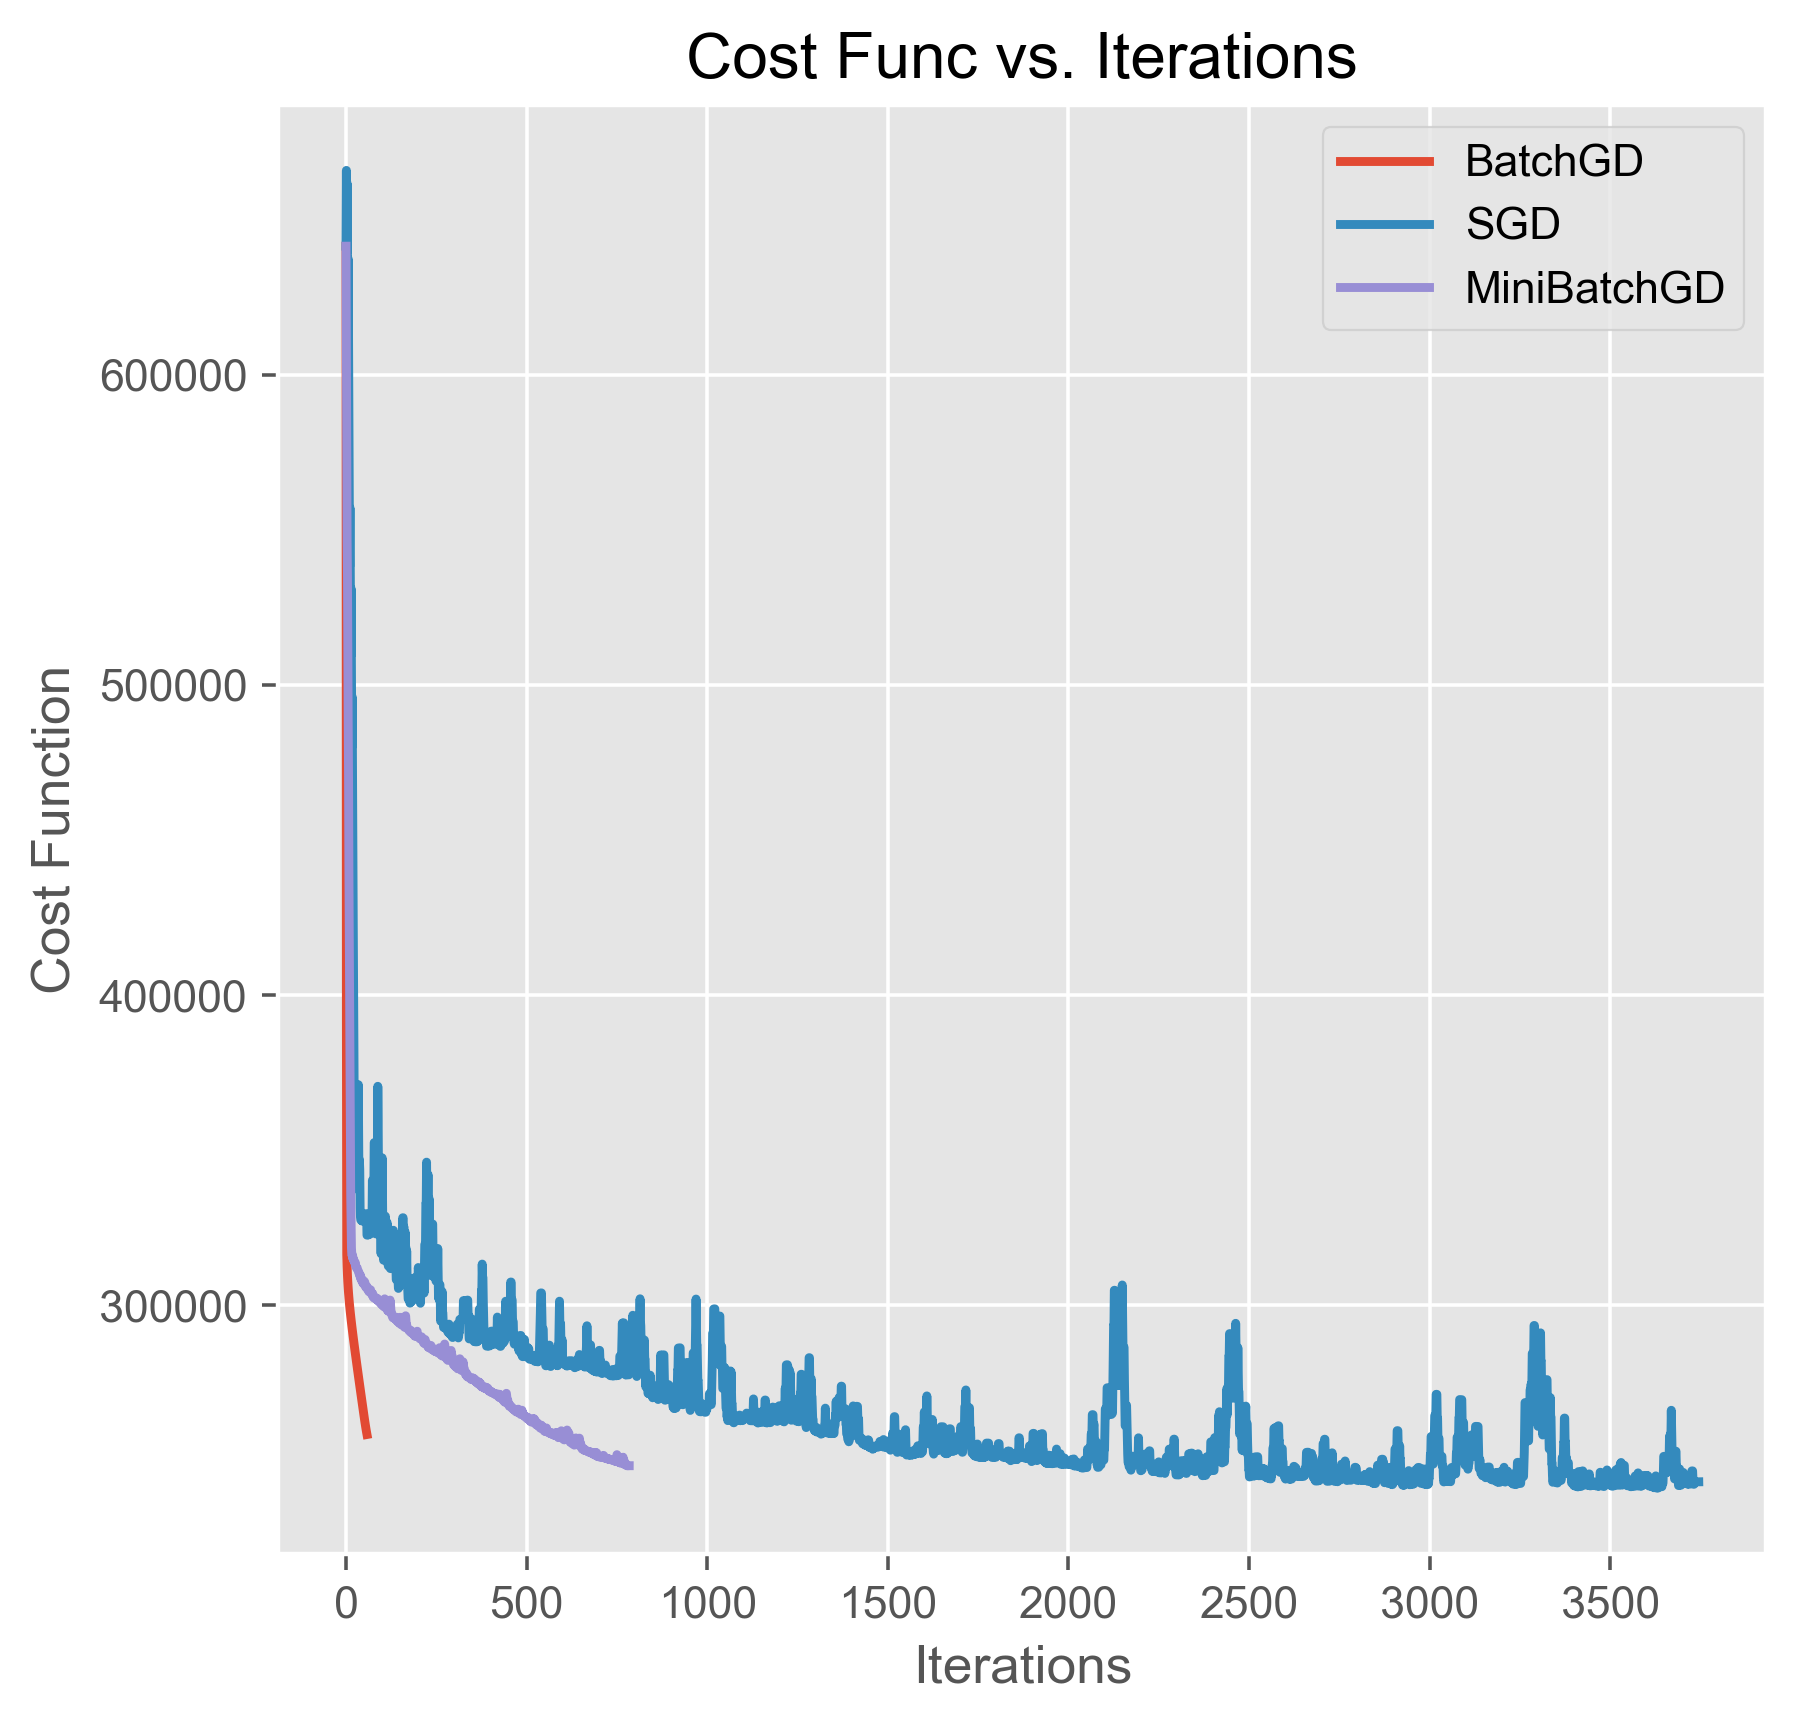

In [8]:
from matplotlib import cm
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams["font.weight"] = "bold"
plt.style.use('ggplot')
fig, ax = plt.subplots(1,1, figsize = (6,6), dpi = 320)
ax.plot(
    np.arange(k_BatchGD + 1), 
    cost_list_BatchGD, 
    linewidth = 2, 
    label = 'BatchGD'
)
ax.plot(
    np.arange(k_SGD + 1), 
    cost_list_SGD, 
    linewidth = 2, 
    label = 'SGD'
)
ax.plot(
    np.arange(k_MiniBatchGD + 1), 
    cost_list_MiniBatchGD, 
    linewidth = 2, 
    label = 'MiniBatchGD'
)
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost Function')
ax.set_title('Cost Func vs. Iterations')
ax.legend()
plt.show()


According to this plot, we can note that BatchGD use extremely less number of iterations to converge, while MiniBatchGD converged in 784 iterations, and SGD converged in more than 3500 iterations. We can see that the cost function of BatchGD decreased without any fluctuation, while StochasticGD and MiniBatchGD have the fluctuation of the value of cost function. However, the time cost for convergence shows another pattern, the BatchGD converged in 1868.47s, the SGD converged in 1241.90s, and the MiniBatchGD converged in 239.05s, which means that the time cost for one iteration of MiniBatchGD is the lowest among these three methods. 